In [1]:
import os
import pandas as pd
from pathlib import Path

# Execute this notebook headlessly using something like:
#
# EXP_FOLDER=~/test_builds/coreutils.exp/ jupyter nbconvert --to html --execute characterize_dataset.ipynb --no-input
#

# MANUAL_EXP_FOLDER = Path.home()/'test_builds'/'astera3.exp'
MANUAL_EXP_FOLDER = Path.home()/'test_builds'/'astera.exp'

# take the env-var-specified experiment if present
EXP_FOLDER = Path(os.environ['EXP_FOLDER']) if 'EXP_FOLDER' in os.environ else MANUAL_EXP_FOLDER

In [2]:
# import wildebeest as wdb
# wdb.get_experiment_names()
ast_json = EXP_FOLDER/'rundata'/'run1'/'0.fighter'/'ast_dumps'/'stripped'/'Func143603-FUN_00143603.json'
[x for x in (EXP_FOLDER/'rundata'/'run1'/'0.fighter'/'ast_dumps'/'stripped').iterdir() if '143603' in x.name]


[]

# Prepare data for PyG Model
*Sticking this here for now for sake of time...*

We need to **quickly** write the code to take our data tables and convert each variable into the format ready to go for PyG

In [3]:
import astlib
from astlib.color_ast import highlight_var_refs, highlight_khop_neighborhood
from astlib.find_all_references import *

run_folder = EXP_FOLDER/'rundata'/'run1'
locals_df = pd.read_csv(run_folder/'locals.csv')
funcs_df = pd.read_csv(run_folder/'functions.csv')

# AHA! DataFrameGroupBy object behaves like an iterable of tuples:
    # [0]: tuple of values for the columns you grouped by
    # [1]: corresponding data frame with this subset of the data

##########################################################
df_list = locals_df.groupby(['BinaryId', 'FunctionStart']).pipe(lambda gb: [x[1] for x in gb])
# --------------------
# TODO: for all locals in this function (start here, we'll see how it evolves)
#       >>> only need to save the data/features we need for the model (and just enough metadata
#           to refer back to the func/var of interest)
##########################################################

# TODO: convert this to a function we call using pipe() above
df = df_list[313]

addr = df.FunctionStart.iloc[0]
ast_file = funcs_df[funcs_df.FunctionStart==addr].iloc[0].AstJson_Strip

ast, slib = astlib.json_to_ast(ast_file)
df.drop(columns=['LocType_Debug','LocRegName_Debug','LocOffset_Debug','LocType_Strip','LocRegName_Strip','LocOffset_Strip'])

# -------------------------------------------
# TODO: for each local... i in range(len(df))
name_strip = df.iloc[0].Name_Strip
# -------------------------------------------

fbody = ast.inner[-1].inner[-1]

# for node in decl_ref_nodes:
#     display(node.parent.parent.parent.render(format_node=highlight_khop_neighborhood(node, 2, 'red')))
df.TypeSeq_Debug

806        PTR,STRUCT
807    PTR,PTR,STRUCT
Name: TypeSeq_Debug, dtype: object

In [4]:
from datatype_recovery.models.dataset import TypeSequenceDataset

ds_params = {
    'name': 'Test',
    'experiment_runs': ['/home/cls0027/test_builds/coreutils.exp/rundata/run1'],
    'copy_data': False
}
dataset = TypeSequenceDataset(ds_params, 'typeseq_data', max_hops=3)
# dataset.download()

In [5]:
dataset.len()

31947

In [6]:
len(dataset)

31947

In [7]:
from datatype_recovery.models.dataset.encoding import TypeSequence

# data = torch.load('typeseq_data/processed/vars-1000_30.pt')
sample = dataset.get(30650)

print(sample.varid)

rgid, bid, funcaddr, sig, vtype = sample.varid

runs_df = pd.read_csv(Path.cwd()/'typeseq_data'/'raw'/'experiment_runs.csv')
bins_df = pd.read_csv(runs_df[runs_df.RunGid==rgid].iloc[0].BinariesCsv)

exp_name = Path(runs_df.iloc[0].RunFolder).parent.parent.stem
print(f'Run {rgid} exp name: {exp_name}')
print(f'Binary name: {bins_df[bins_df.BinaryId==bid].iloc[0].Name}')
print()

run_row = runs_df[runs_df.RunGid==rgid].iloc[0]
locals_df = pd.read_csv(run_row.LocalsCsv if vtype == 'l' else run_row.ParamsCsv)
match_df = locals_df[(locals_df.FunctionStart==funcaddr)&(locals_df.Signature==sig)]
print(match_df.iloc[0])
print()
print(match_df.iloc[0].TypeSeq_Debug)
TypeSequence().decode(sample.y)

# import subprocess
# from wildebeest.utils import cd

# with cd(Path(runs_df.iloc[0].RunFolder).parent.parent):
#     subprocess.run(['wdb', 'info'])


(0, 108, 1074895, '59,91', 'p')
Run 0 exp name: coreutils
Binary name: mknod

FunctionStart             1074895
Name_Debug            right_quote
Signature                   59,91
IsReturnType_Debug          False
Type_Debug                int8_t*
LocType_Debug                 reg
LocRegName_Debug              rdx
LocOffset_Debug               0.0
TypeCategory_Debug        POINTER
TypeSeq_Debug          PTR,int8_t
Name_Strip                param_3
IsReturnType_Strip          False
Type_Strip                int64_t
LocType_Strip                 reg
LocRegName_Strip              rdx
LocOffset_Strip               0.0
TypeCategory_Strip        BUILTIN
TypeSeq_Strip             int64_t
BinaryId                      108
Name: 35401, dtype: object

PTR,int8_t


['PTR']

In [8]:
# ast.inner[-1].inner[-1].inner[-3].render()
# print(ast.inner[-1].inner[-1].inner[-3].inner[2].inner[1].parent)
df.iloc[0]

FunctionStart                       1678442
Name_Debug                           window
Signature             87,97,119,128,128,135
Type_Debug                     _GLFWwindow*
LocType_Debug                         stack
LocRegName_Debug                        NaN
LocOffset_Debug                         -32
TypeCategory_Debug                  POINTER
TypeSeq_Debug                    PTR,STRUCT
Name_Strip                         local_20
Type_Strip                        uint64_t*
LocType_Strip                         stack
LocRegName_Strip                        NaN
LocOffset_Strip                         -32
TypeCategory_Strip                  POINTER
TypeSeq_Strip                  PTR,uint64_t
BinaryId                                  3
Name: 806, dtype: object

In [9]:
df.iloc[0].Type_Debug
df.iloc[0].TypeCategory_Debug

type_seq = df.iloc[0].TypeSeq_Debug.split(',')  # list of str
df.TypeSeq_Strip
type_seq[:1]
# TODO: collect TypeSeq_Debug, split that and encode each entry as the y label
# --> probably should start with FIRST entry only to get end-to-end, then add in the sequence model output?

['PTR']

In [10]:
from datatype_recovery.models.dataset.encoding import encode_typeseq, typeseq_name_to_id

sorted(typeseq_name_to_id().keys())

['ARR',
 'ENUM',
 'FUNC',
 'PTR',
 'STRUCT',
 'UNION',
 '__int128_t',
 '__uint128_t',
 'double',
 'float',
 'float10',
 'int16_t',
 'int32_t',
 'int64_t',
 'int8_t',
 'long double',
 'uint16_t',
 'uint32_t',
 'uint64_t',
 'uint8_t']

In [11]:
# F.one_hot() type_seq
import torch
from torch.nn import functional as F

y = encode_typeseq(type_seq)
y

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

# One-hot encoding approach
Ah... this is probably the best way to do this simply

1. Put the set of possible keys in a **list** (e.g. `['A', 'B', 'C']`)
2. Generate a dictionary mapping each key to its list index: `{name: i for i, name in enumerate(name_list)}`
3. One-hot encode by converting names to ids, then `F.one_hot()`
4. Decode by using `argmax(dim=1)` to convert the `1` to its index, then index into `name_list` directly to
convert back to the original name (*since we used the indices as the ids we have that nice side effect*)

In [12]:


print(type_seq)
print(encode_typeseq(type_seq))
TypeSequence().decode(encode_typeseq(type_seq))

['PTR', 'STRUCT']
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])


['PTR', 'STRUCT']

In [13]:
from datatype_recovery.models.dataset.encoding import encode_astnode, decode_astnode

x = encode_astnode(ast.inner[-1].inner[-1].inner[0])
decode_astnode(x)

'DeclStmt'

In [14]:
from datatype_recovery.models.dataset import VariableGraphBuilder

builder = VariableGraphBuilder(name_strip, ast, max_hops=3, sdb=slib)
node_list, edge_index = builder.build()
node_list

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

In [15]:
import astlib
from astlib.color_ast import highlight_var_refs

ast, slib = astlib.json_to_ast(ast_json)
ast.inner[-1].inner[-1].inner[8].inner[0].inner

# if node.kind == highlight_kind:
#             attrs.font_color = highlight_color
# def highlight_var(varname:str):
#     def do_highlight(node, attrs):
#         if node.kind == 'DeclRefExpr' and node.referencedDecl.name == varname:
#             attrs.font_color = 'red'
#     return do_highlight

ast.render(format_node=highlight_var_refs('param_1'))

FileNotFoundError: [Errno 2] No such file or directory: '/home/cls0027/test_builds/astera.exp/rundata/run1/0.fighter/ast_dumps/stripped/Func143603-FUN_00143603.json'

In [ ]:
pvdecl = ast.inner[-1].inner[0]
pvdecl.name

fbody = ast.inner[-1].inner[-1]
from astlib.find_all_references import *

res = FindAllVarRefs('param_1').visit(fbody)
# res[0].parent.parent.parent.parent.parent.parent
statements = FindAllStatementsContainingVar('param_1').collect_statement_set(fbody)
statements

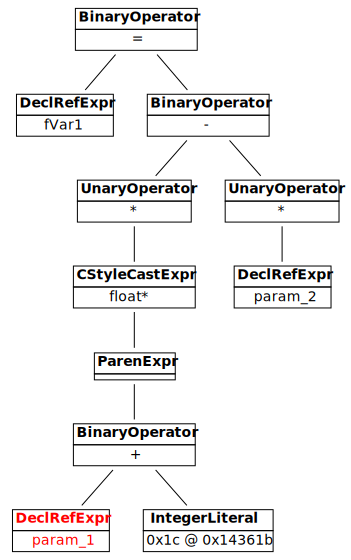

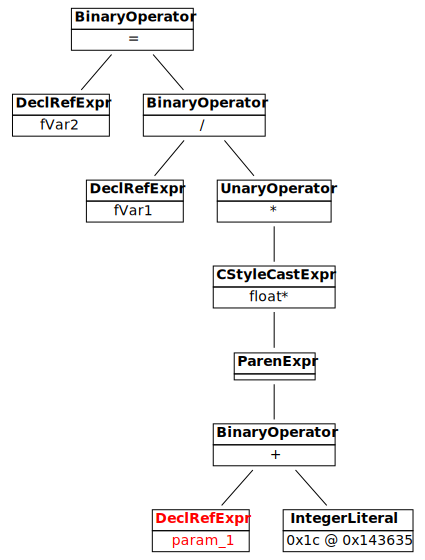

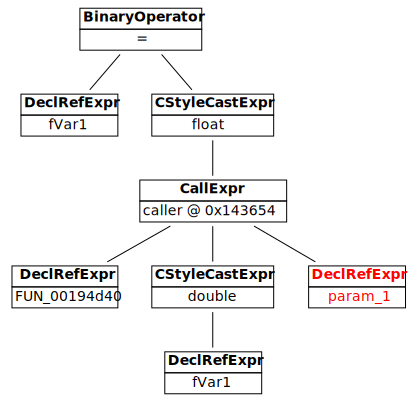

In [ ]:
for s in statements:
    display(s.statement_node.render(format_node=highlight_var_refs('param_1')))